# Universal Approximation, Nonlinearity, and Activation Functions

## Universal Approximation Theorem

**Theorem (Cybenko, 1989; Hornik, 1991)**: A single hidden layer neural network with a finite number of neurons can approximate any continuous function on a compact domain to arbitrary accuracy, provided the activation function is non-constant, bounded, and monotonically increasing.

Mathematically: For any continuous function $f: [0,1] \to \mathbb{R}$ and $\epsilon > 0$, there exists a network:
$$F(x) = \sum_{i=1}^{N} w_i \sigma(v_i x + b_i) + w_0$$

such that $|F(x) - f(x)| < \epsilon$ for all $x \in [0,1]$.

## Why Nonlinearity is Essential

**Key insight**: Without nonlinear activation functions, neural networks collapse to linear models regardless of depth.

**Proof**: Consider a network without activation functions:
$$h_1 = W_1 x + b_1$$
$$h_2 = W_2 h_1 + b_2 = W_2(W_1 x + b_1) + b_2 = (W_2 W_1)x + (W_2 b_1 + b_2)$$

This reduces to: $y = W_{eq} x + b_{eq}$ - a linear function!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use('default')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (14, 10)})

# Generate complex target function
def complex_function(x):
    return 0.5 * np.sin(4*np.pi*x) * np.exp(-2*x) + 0.3 * np.cos(6*np.pi*x)

x_test = np.linspace(0, 1, 200)
y_true = complex_function(x_test)

# Training data
x_train = np.linspace(0, 1, 20)
y_train = complex_function(x_train) + 0.02 * np.random.randn(20)

# Convert to tensors
x_train_t = torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
x_test_t = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)

print(f"Target function: Complex oscillatory with exponential decay")
print(f"Training points: {len(x_train)}")

Target function: Complex oscillatory with exponential decay
Training points: 20


In [2]:
# Demonstrate linear vs nonlinear networks
class LinearNetwork(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, width),
            nn.Linear(width, width),
            nn.Linear(width, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

class NonlinearNetwork(nn.Module):
    def __init__(self, width, activation='tanh'):
        super().__init__()
        if activation == 'tanh':
            act = nn.Tanh()
        elif activation == 'relu':
            act = nn.ReLU()
        elif activation == 'sigmoid':
            act = nn.Sigmoid()
            
        self.layers = nn.Sequential(
            nn.Linear(1, width),
            act,
            nn.Linear(width, width),
            act,
            nn.Linear(width, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

def train_model(model, x_train, y_train, epochs=3000):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        pred = model(x_train)
        loss = criterion(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.item()

# Train models
torch.manual_seed(42)
linear_net = LinearNetwork(50)
tanh_net = NonlinearNetwork(50, 'tanh')
relu_net = NonlinearNetwork(50, 'relu')
sigmoid_net = NonlinearNetwork(50, 'sigmoid')

models = {'Linear': linear_net, 'Tanh': tanh_net, 'ReLU': relu_net, 'Sigmoid': sigmoid_net}

print("Training models...")
for name, model in models.items():
    loss = train_model(model, x_train_t, y_train_t)
    print(f"{name}: Final loss = {loss:.6f}")

Training models...
Linear: Final loss = 0.053952
Tanh: Final loss = 0.000046
ReLU: Final loss = 0.000015
Sigmoid: Final loss = 0.005652


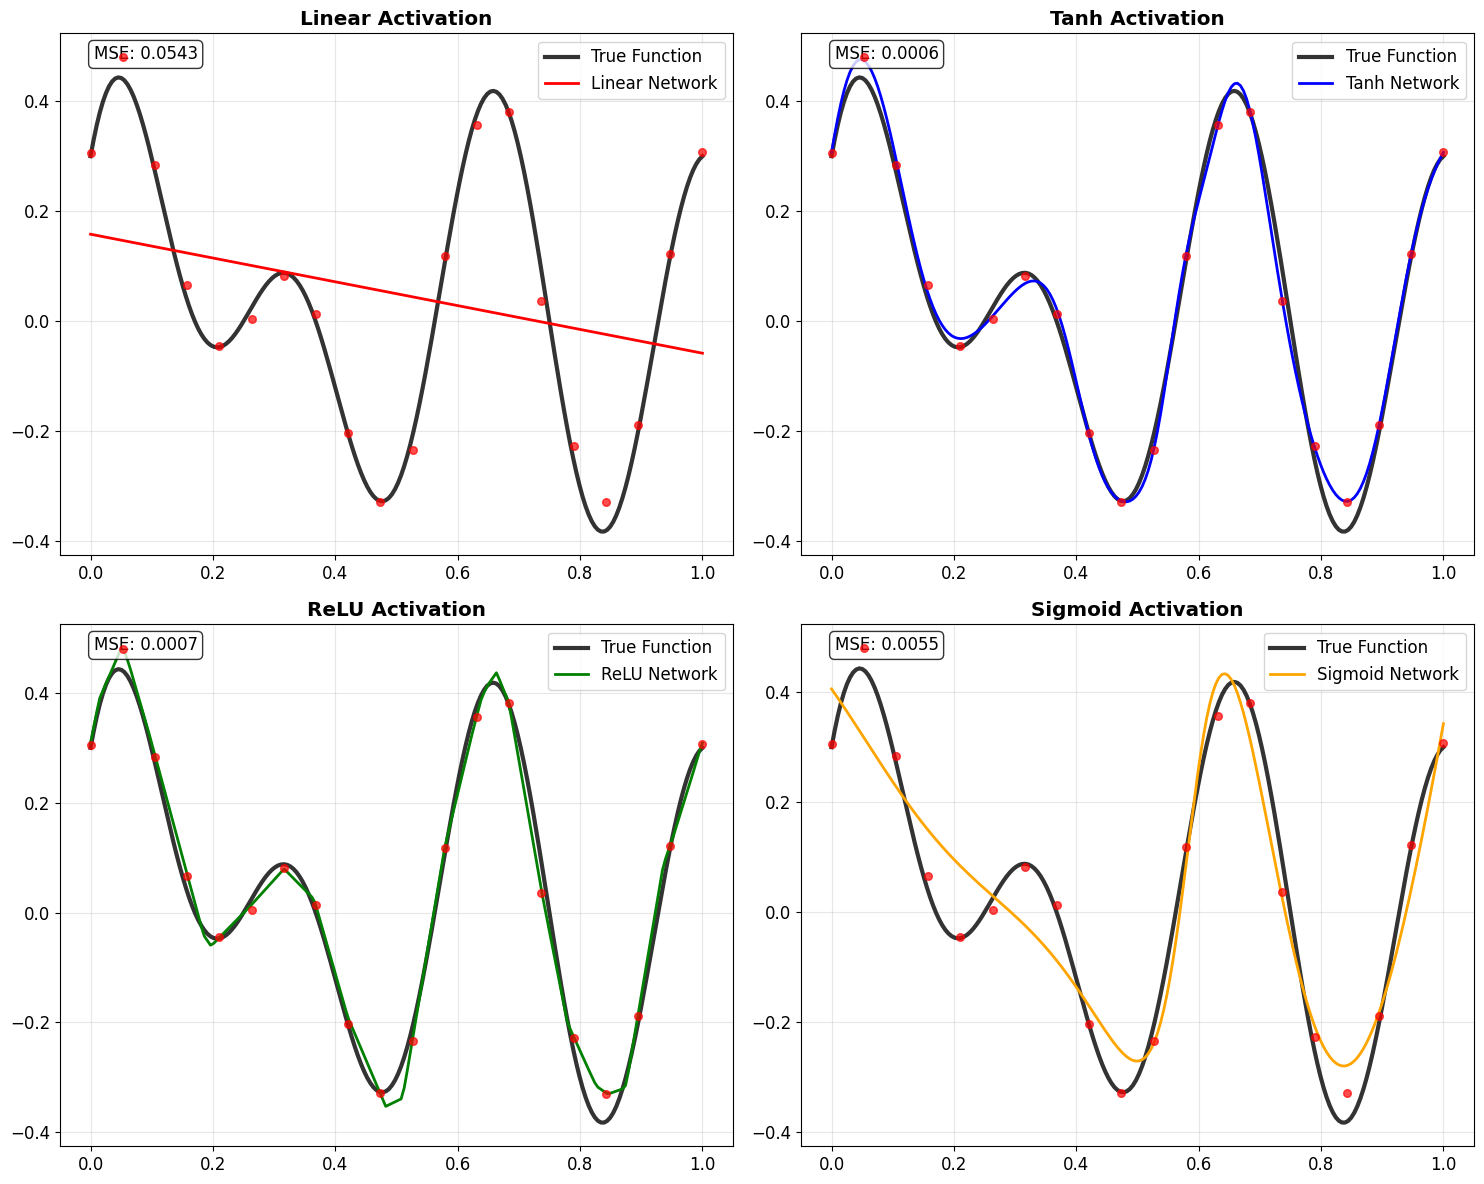

In [3]:
# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
axes = [ax1, ax2, ax3, ax4]
colors = ['red', 'blue', 'green', 'orange']

for ax, (name, model), color in zip(axes, models.items(), colors):
    with torch.no_grad():
        y_pred = model(x_test_t).numpy().flatten()
    
    ax.plot(x_test, y_true, 'k-', linewidth=3, label='True Function', alpha=0.8)
    ax.plot(x_test, y_pred, color=color, linewidth=2, label=f'{name} Network')
    ax.scatter(x_train, y_train, color='red', s=30, alpha=0.7, zorder=5)
    
    mse = np.mean((y_pred - y_true)**2)
    ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(f'{name} Activation', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Activation Functions: Properties and Applications

### Sigmoid: $\sigma(x) = \frac{1}{1+e^{-x}}$
- **Range**: (0, 1)
- **Use**: Binary classification output
- **Issue**: Vanishing gradients

### Tanh: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
- **Range**: (-1, 1)
- **Use**: Hidden layers, zero-centered
- **Issue**: Vanishing gradients

### ReLU: $\text{ReLU}(x) = \max(0, x)$
- **Range**: [0, ∞)
- **Use**: Most hidden layers (default choice)
- **Issue**: Dead neurons

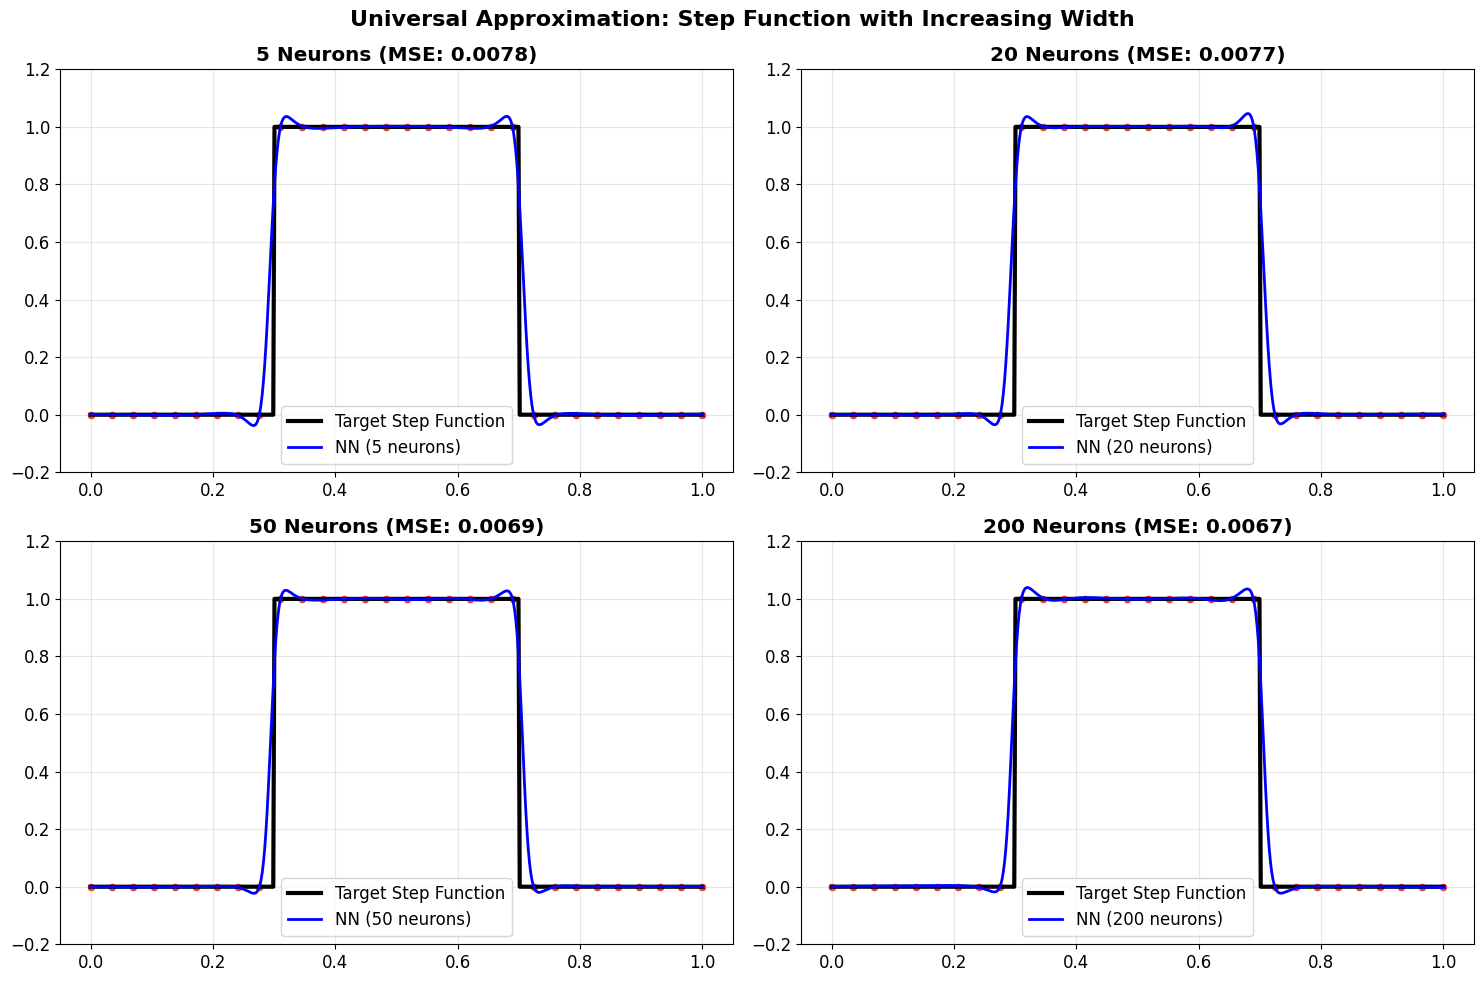

In [4]:
# Demonstrate Universal Approximation with step function approximation
def step_function(x):
    return (x > 0.3).astype(float) * (x < 0.7).astype(float)

# Approximate step function with increasing number of neurons
x_fine = np.linspace(0, 1, 500)
y_step = step_function(x_fine)

# Generate training data for step function
x_step_train = np.linspace(0, 1, 30)
y_step_train = step_function(x_step_train)
x_step_train_t = torch.tensor(x_step_train.reshape(-1, 1), dtype=torch.float32)
y_step_train_t = torch.tensor(y_step_train.reshape(-1, 1), dtype=torch.float32)
x_fine_t = torch.tensor(x_fine.reshape(-1, 1), dtype=torch.float32)

# Test different network widths
widths = [5, 20, 50, 200]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, width in enumerate(widths):
    torch.manual_seed(42)
    model = NonlinearNetwork(width, 'tanh')
    train_model(model, x_step_train_t, y_step_train_t, epochs=5000)
    
    with torch.no_grad():
        y_pred = model(x_fine_t).numpy().flatten()
    
    axes[i].plot(x_fine, y_step, 'k-', linewidth=3, label='Target Step Function')
    axes[i].plot(x_fine, y_pred, 'b-', linewidth=2, label=f'NN ({width} neurons)')
    axes[i].scatter(x_step_train, y_step_train, color='red', s=20, alpha=0.7)
    
    mse = np.mean((y_pred - y_step)**2)
    axes[i].set_title(f'{width} Neurons (MSE: {mse:.4f})', fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-0.2, 1.2)

plt.suptitle('Universal Approximation: Step Function with Increasing Width', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Classification example showing ReLU nonlinearity
from sklearn.datasets import make_moons

# Generate moon dataset
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

class Classifier(nn.Module):
    def __init__(self, hidden_size, use_activation=True):
        super().__init__()
        self.linear1 = nn.Linear(2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU() if use_activation else nn.Identity()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return self.sigmoid(x)

# Train linear vs nonlinear classifiers
torch.manual_seed(42)
linear_clf = Classifier(10, use_activation=False)
nonlinear_clf = Classifier(10, use_activation=True)

def train_classifier(model, X, y, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.item()

print("Training classifiers...")
linear_loss = train_classifier(linear_clf, X_tensor, y_tensor)
nonlinear_loss = train_classifier(nonlinear_clf, X_tensor, y_tensor)
print(f"Linear classifier loss: {linear_loss:.4f}")
print(f"Nonlinear classifier loss: {nonlinear_loss:.4f}")

Training classifiers...
Linear classifier loss: 0.2721
Nonlinear classifier loss: 0.0011


In [ ]:
# Visualize classification results
def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid_points).numpy()
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Prediction')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    colors = ['red', 'blue']
    for i in range(2):
        plt.scatter(X[y.flatten() == i, 0], X[y.flatten() == i, 1], 
                   c=colors[i], s=50, alpha=0.8, edgecolors='black')
    
    plt.title(title, fontweight='bold')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_decision_boundary(linear_clf, X, y, 'Linear Classifier (No Activation)')

plt.subplot(1, 2, 2)
plot_decision_boundary(nonlinear_clf, X, y, 'Nonlinear Classifier (ReLU)')

plt.tight_layout()
plt.show()

# Calculate accuracies
with torch.no_grad():
    linear_pred = (linear_clf(X_tensor) > 0.5).float()
    nonlinear_pred = (nonlinear_clf(X_tensor) > 0.5).float()
    
    linear_acc = (linear_pred == y_tensor).float().mean()
    nonlinear_acc = (nonlinear_pred == y_tensor).float().mean()

print(f"\nClassification Accuracy:")
print(f"Linear classifier: {linear_acc:.3f}")
print(f"Nonlinear classifier: {nonlinear_acc:.3f}")

## Key Insights

### 1. **Universal Approximation is Theoretical**
- Single layer networks *can* approximate any function
- But may require impractically many neurons
- Width requirement grows exponentially with complexity

### 2. **Nonlinearity is Fundamental**
- Without activation functions: $f(f(f(x))) = f(x)$ (linear)
- With activation functions: Infinite representational power
- Each neuron creates a different "basis function"

### 3. **Activation Function Choice Matters**
- **Sigmoid/Tanh**: Good for smooth functions, suffer from vanishing gradients
- **ReLU**: Efficient, avoids vanishing gradients, risk of dead neurons
- **Problem-dependent**: No universal best choice

### 4. **Practical Limitations**
- Universal approximation doesn't guarantee efficient approximation
- Training may not find optimal parameters
- Generalization vs. memorization trade-off

**Next**: We'll see where single-layer networks fundamentally fail, motivating the need for depth.